# Time Series HRRR Statistics from OSG

In [1]:
%matplotlib inline
import h5py
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
from collections import OrderedDict

import sys
import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v2')
from BB_downloads.HRRR_S3 import *
from BB_wx_calcs.wind import wind_uv_to_spd
from BB_basemap.draw_maps import draw_CONUS_HRRR_map
from BB_MesoWest.MesoWest_STNinfo import get_station_info
from BB_MesoWest.MesoWest_timeseries import get_mesowest_ts
from BB_data.grid_manager import pluck_point_new

In [2]:
from matplotlib.dates import DateFormatter
formatter = DateFormatter('%b\n%d')

import matplotlib as mpl 
mpl.rcParams['figure.figsize'] = [15, 6]
mpl.rcParams['figure.titlesize'] = 15
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['lines.linewidth'] = 1.8
mpl.rcParams['grid.linewidth'] = .25
mpl.rcParams['figure.subplot.wspace'] = 0.05
mpl.rcParams['figure.subplot.hspace'] = 0.05
mpl.rcParams['legend.fontsize'] = 8
mpl.rcParams['legend.framealpha'] = .75
mpl.rcParams['legend.loc'] = 'best'
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.dpi'] = 100

In [3]:
m = draw_CONUS_HRRR_map()

### Get lat/lon grid from file for plotting

In [4]:
DIR = '/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/'
latlon_file = h5py.File(DIR+'OSG_HRRR_latlon.h5', 'r')
lat = latlon_file['latitude'].value
lon = latlon_file['longitude'].value

### Get a point from the grid (multiprocessor)

In [5]:
def get_point_MP(inputs):
    """
    Function for MultiProcessing:
    Return the value from a point in the HDF5 file array
    """
    FILE, STAT, ROW, COL = inputs
    try:
        with h5py.File(FILE, 'r') as f:
            return f[STAT][ROW][COL]
    except:
        #print "COULD NOT GET", FILE
        return np.nan

-------

# Time Series

### Input Arguments
statistic can be from the list:  
`mean, p00, p01, p02, p03, p04, p05, p10, p15, p25, p33, p50, p66, p75, p90, p95, p96, p97, p98, p99, p100`

In [13]:
statistics = ['p05', 'p50', 'p95']
var = 'TMP:2 m'
stn = 'WBB'
fxx = 0

hours = range(24)
#hours = [18]

# Range to get MesoWest and HRRR values (eDATE is exclusive)
sDATE = datetime(2017, 1, 1)
eDATE = datetime(2017, 12, 31)

plot_HRRR = False
plot_MW = True

##### Additional Setup

In [14]:
variable = var.replace(':', '_').replace(' ', '_')
DIR = '/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/%s/' % (variable)

if var == 'TMP:2 m':
    MWvar = 'air_temp'
elif var == 'DPT:2 m':
    MWvar = 'dew_point_temperature'
elif var == 'UVGRD:10 m':
    MWvar = 'wind_speed'
else:
    print "NO MATCHING VAR AND MESOWEST VAR"

if (eDATE-sDATE).days < 365:
    months = range(sDATE.month,eDATE.month+1)
else:
    months = range(1,13)
days = [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

# Dates (with leap year)
HOURS = np.sum(days[0:len(months)])*24 # number of days times 24
DATES = np.array([datetime(2016, 1, 1) + timedelta(hours = h) for h in range(HOURS)])
DATES = DATES[::24/len(hours)] # in case we don't request all 24 hours


# Plot Window (convert needs to be a leap year, so use 2016)
if (eDATE-sDATE).days >=365:
    sPLOT = datetime(2016, sDATE.month, sDATE.day)
    ePLOT = datetime(2017, eDATE.month, eDATE.day)
else:
    sPLOT = datetime(2016, sDATE.month, sDATE.day)
    ePLOT = datetime(2016, eDATE.month, eDATE.day)

### Get a time series for a point

In [15]:
# Get MewsoWest Time Series
if plot_MW:
    # Get MesoWest Time Series
    a = get_mesowest_ts(stn, sDATE, eDATE, variables=MWvar,)

    # Convert datetime to a leap year date so we can easily plot them with percentiles, sharing the axis.
    MW_DATES = [datetime(2016, d.month, d.day, d.hour, d.minute) for d in a['DATETIME']]

# Get HRRR Time Series for analysis (f00)
if plot_HRRR:
    if var == 'UVGRD:10 m':
        HRRR_date, U = point_hrrr_time_series(sDATE, eDATE,
                                              variable='UGRD:10 m',
                                              lat=b['LAT'][0], lon=b['LON'][0],
                                              verbose=False)
        HRRR_date, V = point_hrrr_time_series(sDATE, eDATE,
                                              variable='UGRD:10 m',
                                              lat=b['LAT'][0], lon=b['LON'][0],
                                              verbose=False)
        HRRR_val = wind_uv_to_spd(U, V)

    else:
        HRRR_date, HRRR_val = point_hrrr_time_series(sDATE, eDATE,
                                                     variable='TMP:2 m',
                                                     lat=b['LAT'][0], lon=b['LON'][0],
                                                     verbose=False)
        HRRR_val = HRRR_val-273.15

    HRRR_DATES = [datetime(2016, d.month, d.day, d.hour, d.minute) for d in HRRR_date]

In [16]:
# Get Time Series Data for each requested Statistic
# HTS is the HRRR-statistic Time Series

# MesoWest Station Info
b = get_station_info([stn])

# Pluck point
point = pluck_point_new(b['LAT'][0], b['LON'][0], lat, lon)

print "Station:", stn
print "Grid Point:", point
print "Variable:", var, 'and', MWvar
print "Statistic:", statistics

HTS = OrderedDict()
for i, stat in enumerate(statistics):
    # Multiprocessing :)
    args = [[DIR+'OSG_HRRR_%s_m%02d_d%02d_h%02d_f00.h5' % \
            (variable, month, day, hour), stat, point[0][0], point[1][0]] \
            for month in months for day in range(1,days[month-1]+1) for hour in hours]
    timer = datetime.now()
    num_proc = multiprocessing.cpu_count()
    p = multiprocessing.Pool(num_proc)
    HTS[stat] = np.array(p.map(get_point_MP, args))
    p.close()
    if var == 'TMP:2 m':
        HTS[stat] = HTS[stat]-273.15
        ylabel = '2 m Temperature (C)'
    elif var == 'DPT:2 m':
        HTS[stat] = HTS[stat]-273.15
        ylabel = '2 m Dew Point (C)'
    elif var == 'UVGRD:10 m':
        ylabel = r'10 m Wind Speed (m s$\mathregular{^{-1}}$)'
    print "%s Timer:%s" % (stat, datetime.now()-timer)

Station: WBB
Grid Point: (array([644]), array([498]))
Variable: TMP:2 m and air_temp
Statistic: ['p05', 'p50', 'p95']
p05 Timer:0:00:04.476086
p50 Timer:0:00:03.377925
p95 Timer:0:00:03.242183


### Create Figure

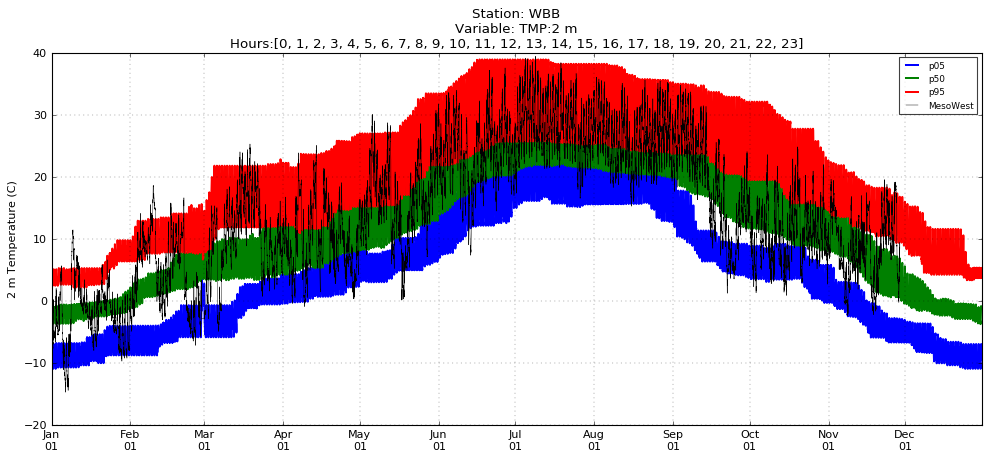

In [17]:
for i, stat in enumerate(HTS.keys()):  
    plt.plot(DATES, HTS[stat], label=stat)

plt.title('Station: %s\nVariable: %s\nHours:%s' % (stn, var, hours))
plt.ylabel(ylabel)

plt.gca().xaxis.set_major_formatter(formatter)

if plot_MW:
    plt.plot(MW_DATES, a[MWvar], label='MesoWest', color='k', lw=0.4)

plt.xlim([sPLOT, ePLOT])
plt.legend()
plt.grid()

### Fill Between Percentiles

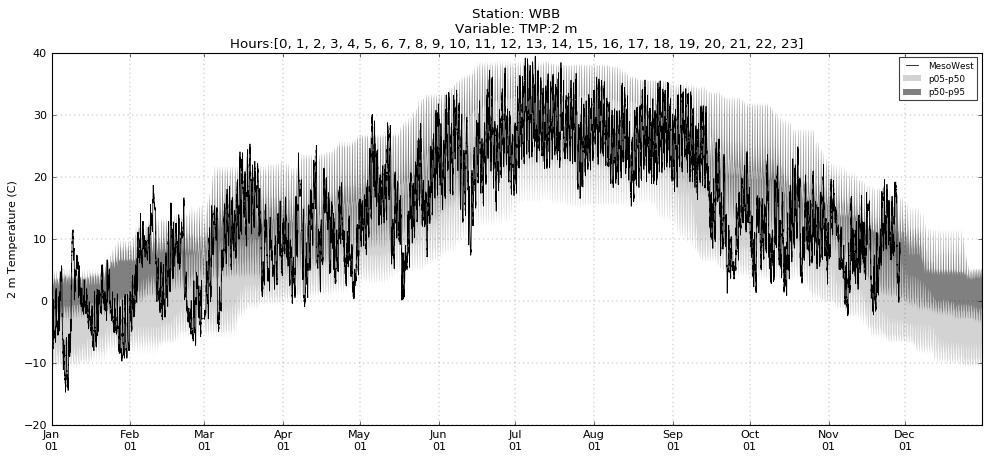

In [18]:
plt.fill_between(DATES, HTS['p05'], HTS['p50'], facecolor='lightgrey',linewidth=0, label='p05-p50')
plt.fill_between(DATES, HTS['p50'], HTS['p95'], facecolor='grey', linewidth=0, label='p50-p95')

plt.title('Station: %s\nVariable: %s\nHours:%s' % (stn, var, hours))
plt.ylabel(ylabel)

plt.gca().xaxis.set_major_formatter(formatter)

if plot_MW:
    plt.plot(MW_DATES, a[MWvar], label='MesoWest', color='k', lw=0.7)

if plot_HRRR:
    plt.plot(HRRR_DATES, HRRR_val, color='r', label='HRRR f00')

plt.xlim([sPLOT, ePLOT])
plt.legend()
plt.grid()